# Explore DSL

This notebook is an experimental approach on solving the ARC challenge. See https://arcprize.org/ for more details.

In [8]:
from pathlib import Path

from arc2024.data import FewShotDataset
from arc2024.utils import plot

## Prepare Dataset

In [9]:
dataset = FewShotDataset(dataset_dir=Path('datasets'))
dataset

# DSL

In [10]:
import sys
sys.path.append('./arc2024/dsl')

import torch
from arc2024.dsl.dsl import vmirror, hmirror, dmirror, rot180, rot270

dsl_to_tuples = lambda g: tuple(tuple(r) for r in g)
dsl_to_lists = lambda g: list(list(r) for r in g)

def dsl_apply(dsl_f, X: torch.Tensor) -> torch.Tensor:
    input = dsl_to_tuples(X.squeeze(0).tolist())
    output = dsl_to_lists(dsl_f(input))
    return torch.tensor(output, dtype=torch.float).unsqueeze(0)

dsl_names = ['vmirror', 'hmirror', 'dmirror', 'rot180', 'rot270']
dsl = [vmirror, hmirror, dmirror, rot180, rot270]
dsl    

[<function arc2024.dsl.dsl.vmirror(piece: Union[Tuple[Tuple[int]], FrozenSet[Tuple[int, Tuple[int, int]]], FrozenSet[Tuple[int, int]]]) -> Union[Tuple[Tuple[int]], FrozenSet[Tuple[int, Tuple[int, int]]], FrozenSet[Tuple[int, int]]]>,
 <function arc2024.dsl.dsl.hmirror(piece: Union[Tuple[Tuple[int]], FrozenSet[Tuple[int, Tuple[int, int]]], FrozenSet[Tuple[int, int]]]) -> Union[Tuple[Tuple[int]], FrozenSet[Tuple[int, Tuple[int, int]]], FrozenSet[Tuple[int, int]]]>,
 <function arc2024.dsl.dsl.dmirror(piece: Union[Tuple[Tuple[int]], FrozenSet[Tuple[int, Tuple[int, int]]], FrozenSet[Tuple[int, int]]]) -> Union[Tuple[Tuple[int]], FrozenSet[Tuple[int, Tuple[int, int]]], FrozenSet[Tuple[int, int]]]>,
 <function arc2024.dsl.dsl.rot180(grid: Tuple[Tuple[int]]) -> Tuple[Tuple[int]]>,
 <function arc2024.dsl.dsl.rot270(grid: Tuple[Tuple[int]]) -> Tuple[Tuple[int]]>]

# PoC: One Step Solutions using Equality

Challenge 67a3c6ac: tensor([3., 0., 0., 0., 0.]) => vmirror() after 3.414154052734375ms


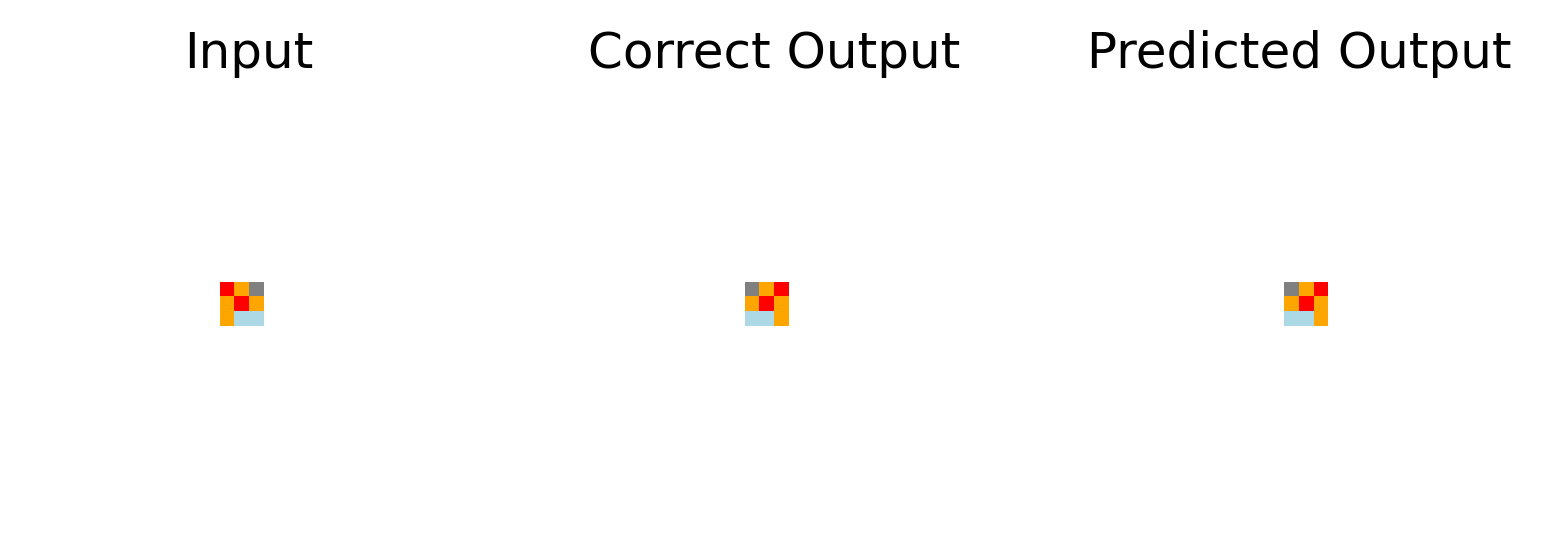

Challenge 68b16354: tensor([0., 3., 0., 0., 0.]) => hmirror() after 4.485130310058594ms


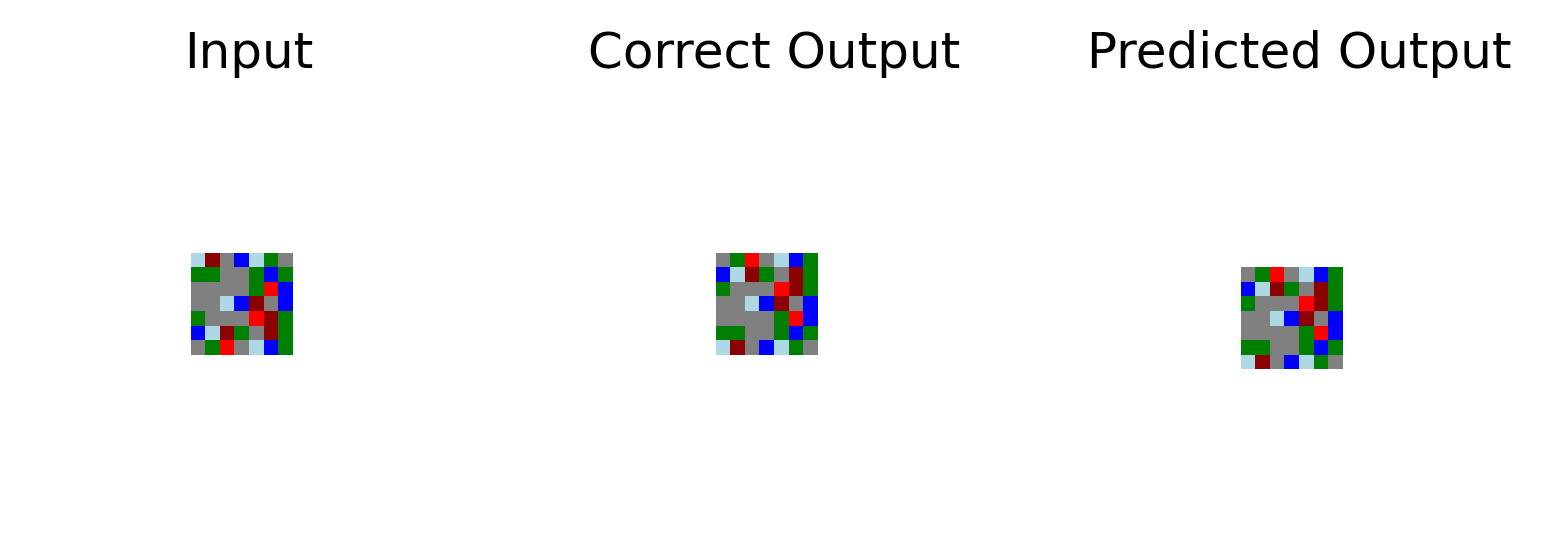

Challenge 74dd1130: tensor([0., 0., 4., 0., 0.]) => dmirror() after 5.892515182495117ms


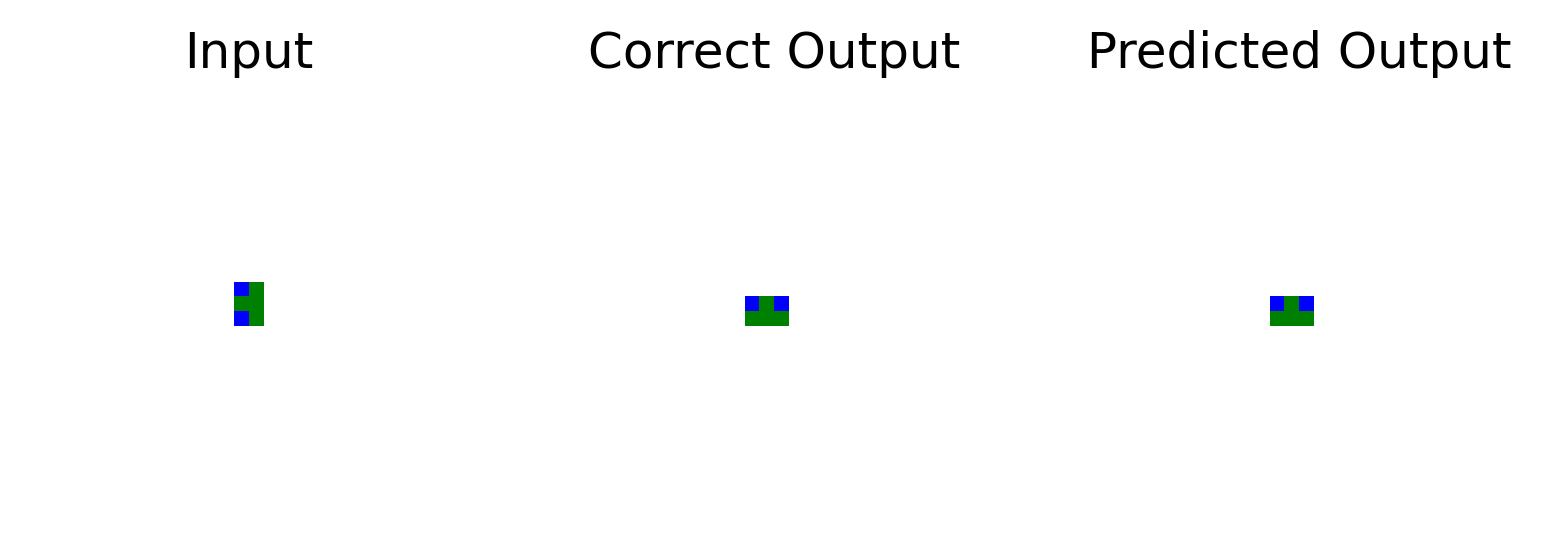

Challenge 3c9b0459: tensor([0., 0., 0., 4., 0.]) => rot180() after 5.255937576293945ms


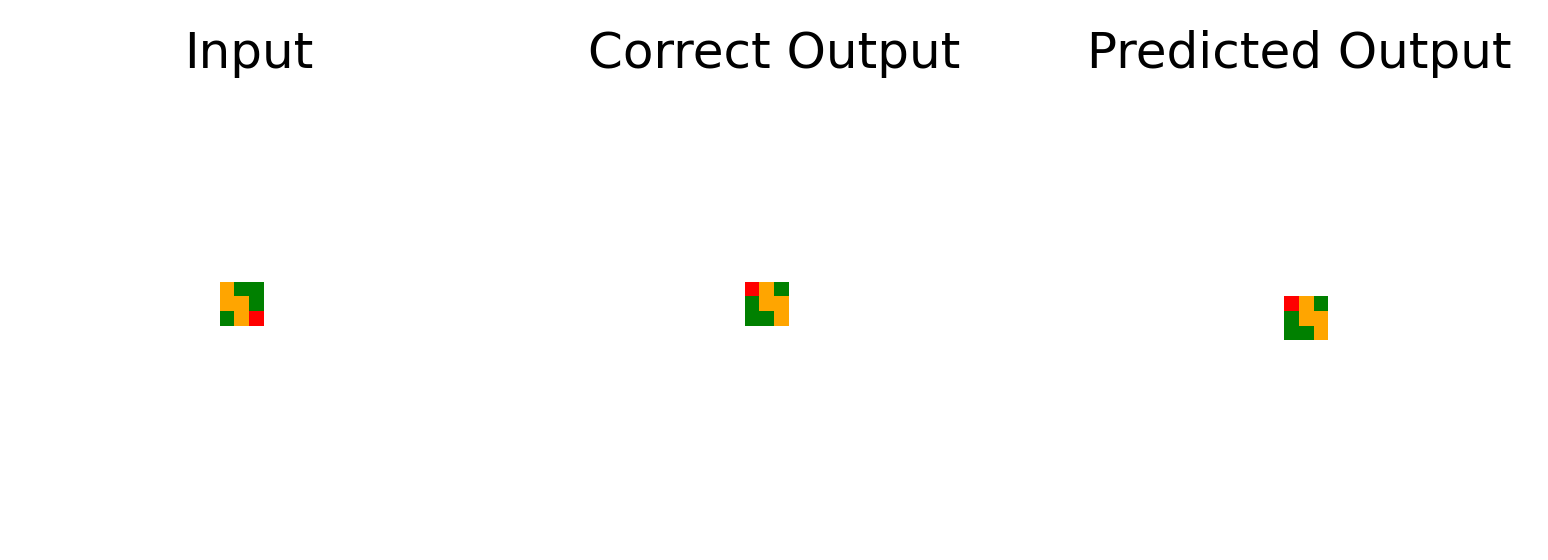

In [11]:
import torch
import time

for challenge_id in ['67a3c6ac', '68b16354', '74dd1130', '3c9b0459']:
    X_samples, y_samples = dataset.get_samples(challenge_id)
    
    start_time = time.time()
    dsl_f_ssim = torch.zeros(len(dsl), dtype=torch.float)
    for i, X_sample in enumerate(X_samples):
        for k, dsl_f in enumerate(dsl):
            y_sample_pred = dsl_apply(dsl_f, X_sample).unsqueeze(0)
            y_sample = y_samples[i].unsqueeze(0)
            
            y_sample_pred_unpadded = dataset.unpad(y_sample_pred.squeeze(0).squeeze(0))
            y_sample_unpadded = dataset.unpad(y_sample.squeeze(0).squeeze(0))
    
            # Calculate similarity between correct solution and after dsl_f has been applied:
            ssim_value = 1.0 if torch.equal(y_sample_unpadded, y_sample_pred_unpadded) else 0.0
            dsl_f_ssim[k] += ssim_value
    
    # Best match is the dsl_f with the highest ssim score:
    dsl_f_index = dsl_f_ssim.argmax()
    end_time = time.time()
    
    challenge_index = dataset.test_challenge_ids.index(challenge_id)
    X, y, _ = dataset.test_challenges[challenge_index]
    y_pred = dsl_apply(dsl[dsl_f_index], X)
    
    print(f"Challenge {challenge_id}: {dsl_f_ssim} => {dsl_names[dsl_f_index]}() after {(end_time - start_time) * 1000}ms")
    plot.input_and_output(
        X,
        y,
        y_pred=y_pred
    )

## PoC: One Step Solutions using SSIM

Challenge 67a3c6ac: tensor([3.0000, 2.9666, 2.9687, 2.9734, 2.9670]) => vmirror() after 46.724796295166016ms


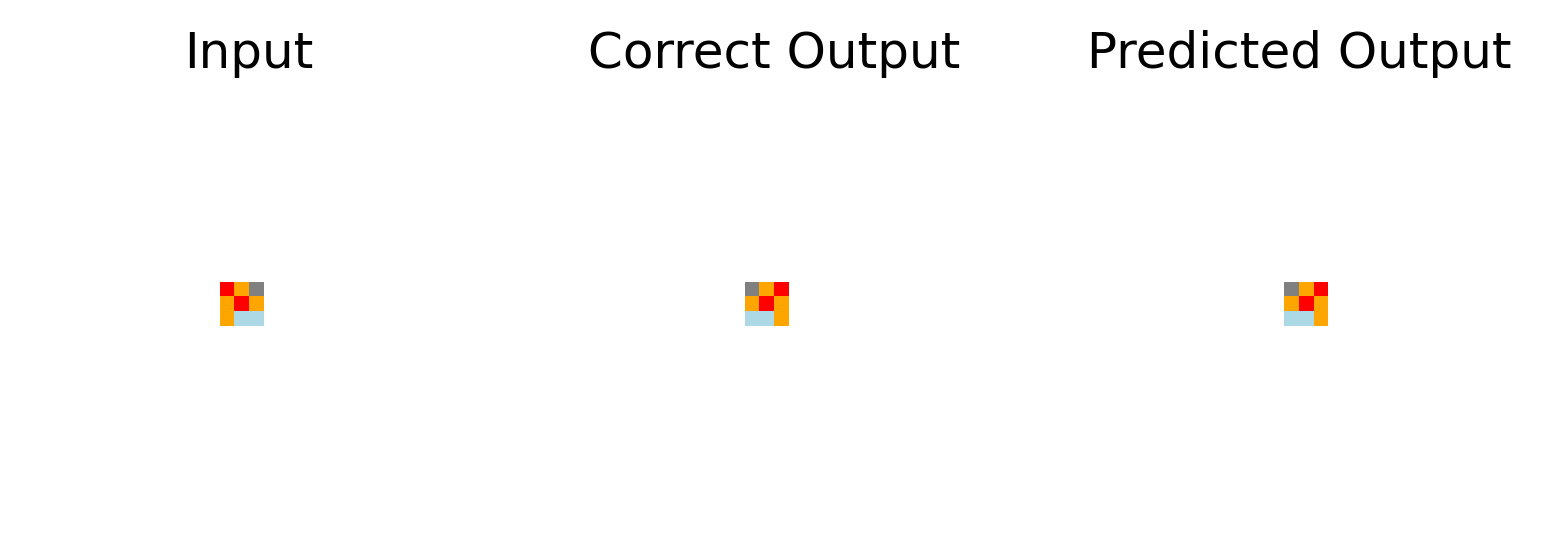

Challenge 68b16354: tensor([2.9650, 3.0000, 2.9730, 2.9798, 2.9799]) => hmirror() after 18.0513858795166ms


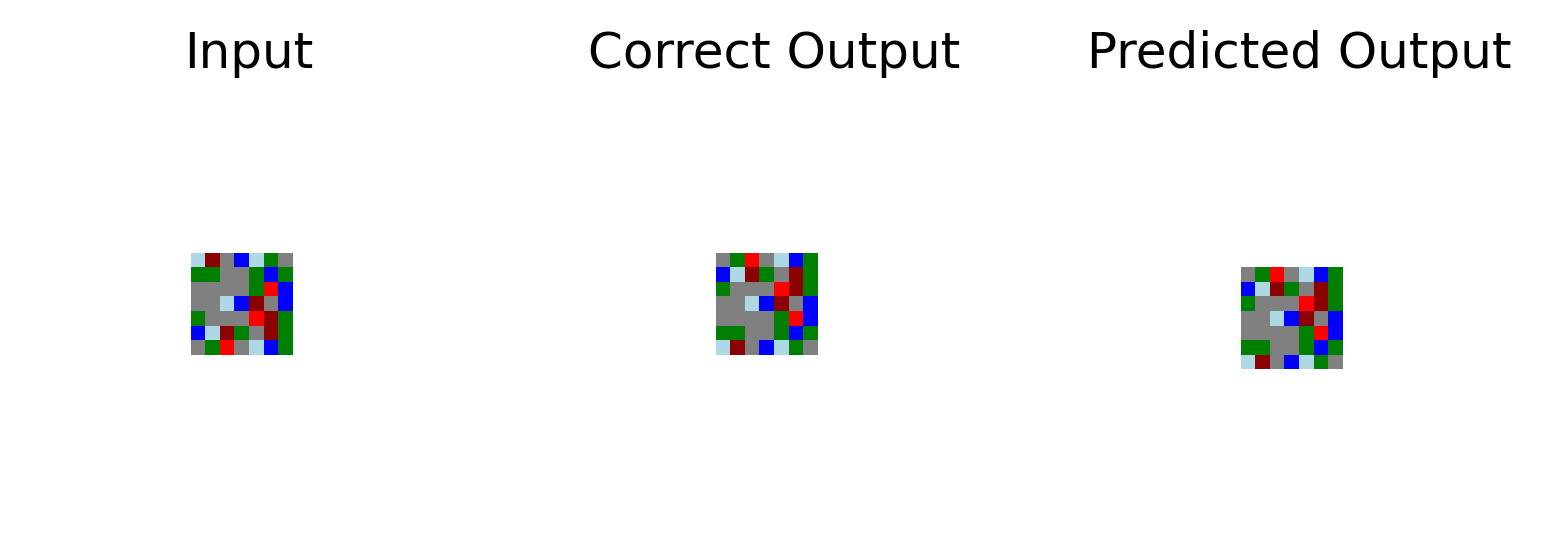

Challenge 74dd1130: tensor([3.9922, 3.9922, 4.0000, 3.9958, 3.9951]) => dmirror() after 31.20255470275879ms


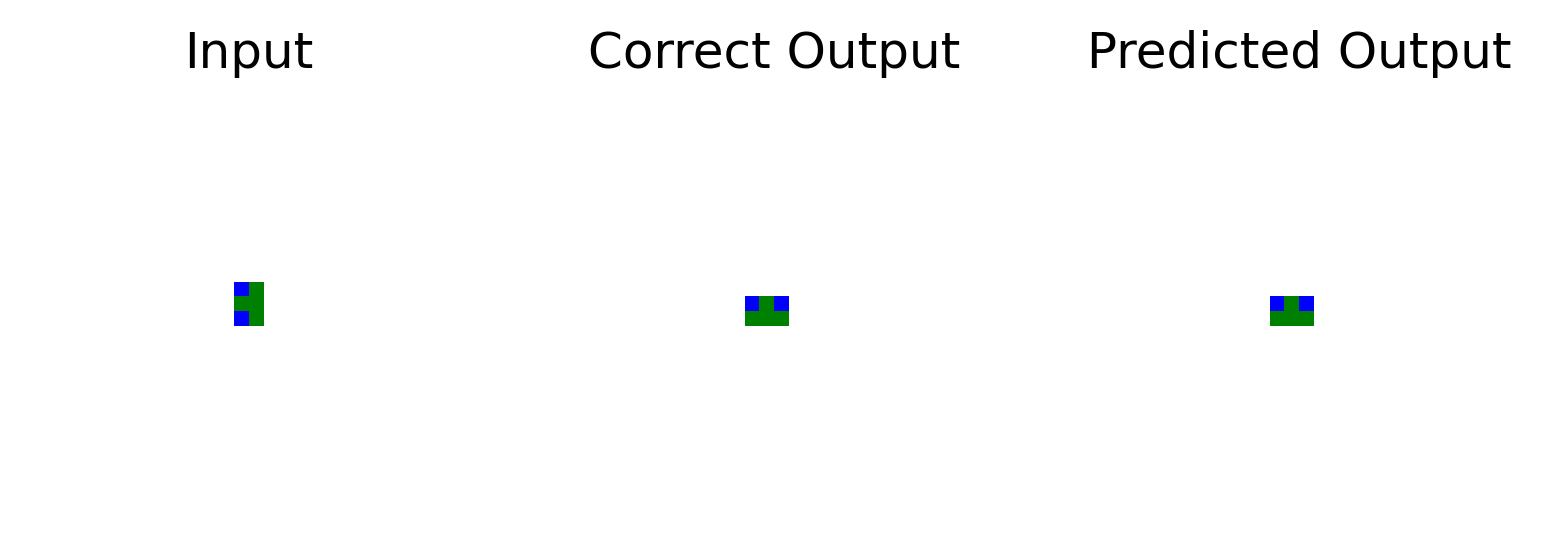

Challenge 3c9b0459: tensor([3.9941, 3.9966, 3.9930, 4.0000, 3.9924]) => rot180() after 30.76004981994629ms


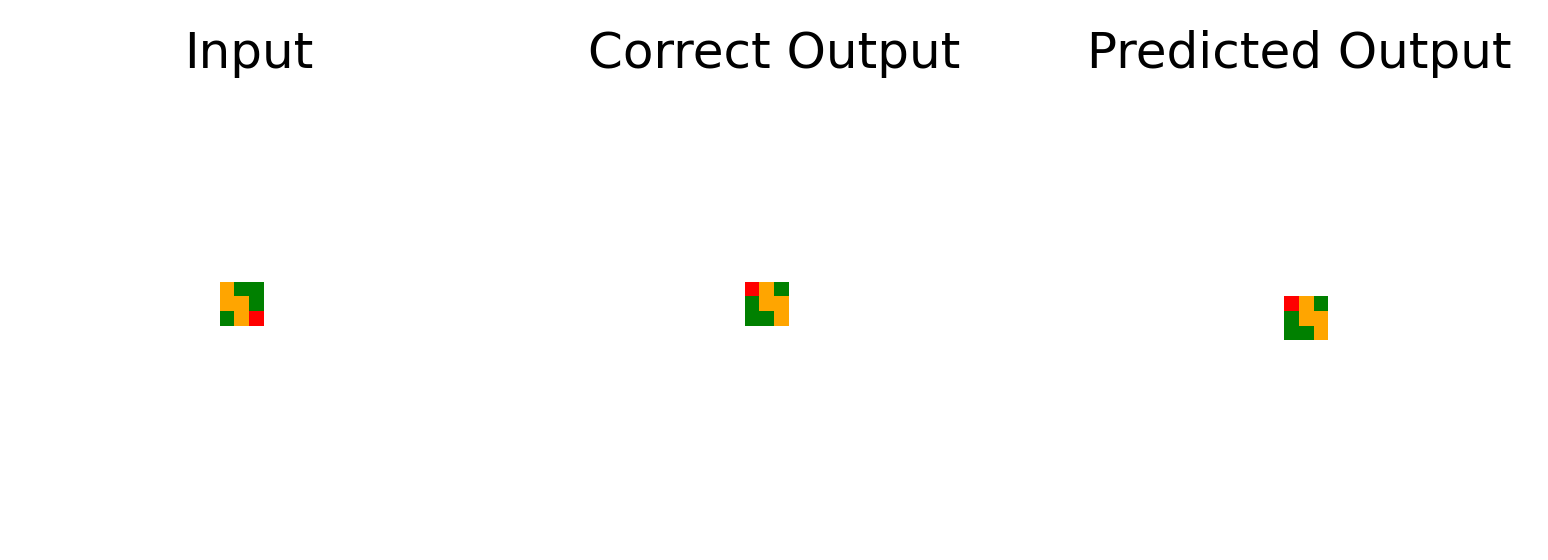

In [12]:
import torch
import time

from torchmetrics.image import StructuralSimilarityIndexMeasure

ssim = StructuralSimilarityIndexMeasure(
    gaussian_kernel=False,
    kernel_size=1,
    data_range=(0, 9),
    reduction=None
)

for challenge_id in ['67a3c6ac', '68b16354', '74dd1130', '3c9b0459']:
    X_samples, y_samples = dataset.get_samples(challenge_id)
    
    start_time = time.time()
    dsl_f_ssim = torch.zeros(len(dsl), dtype=torch.float)
    for i, X_sample in enumerate(X_samples):
        for k, dsl_f in enumerate(dsl):
            y_sample_pred = dsl_apply(dsl_f, X_sample).unsqueeze(0)
            y_sample = y_samples[i].unsqueeze(0)
                    
            y_sample_pred_unpadded = dataset.blow(dataset.unpad(y_sample_pred.squeeze(0).squeeze(0))).unsqueeze(0).unsqueeze(0)
            y_sample_unpadded = dataset.blow(dataset.unpad(y_sample.squeeze(0).squeeze(0))).unsqueeze(0).unsqueeze(0)
            
            # Calculate similarity between correct solution and after dsl_f has been applied:
            ssim_value = ssim(y_sample_unpadded, y_sample_pred_unpadded)
            dsl_f_ssim[k] += ssim_value
    
    # Best match is the dsl_f with the highest ssim score:
    dsl_f_index = dsl_f_ssim.argmax()
    end_time = time.time()
    
    challenge_index = dataset.test_challenge_ids.index(challenge_id)
    X, y, _ = dataset.test_challenges[challenge_index]
    y_pred = dsl_apply(dsl[dsl_f_index], X)

    print(f"Challenge {challenge_id}: {dsl_f_ssim} => {dsl_names[dsl_f_index]}() after {(end_time - start_time) * 1000}ms")
    plot.input_and_output(
        X,
        y,
        y_pred=dsl_apply(dsl[dsl_f_index], X)
    )

## PoC: Multi Step Solutions using SSIM

Challenge 67a3c6ac: tensor([0.9988, 0.9991, 0.9984, 1.0000, 0.9984]) => vmirror() after 27.311325073242188ms


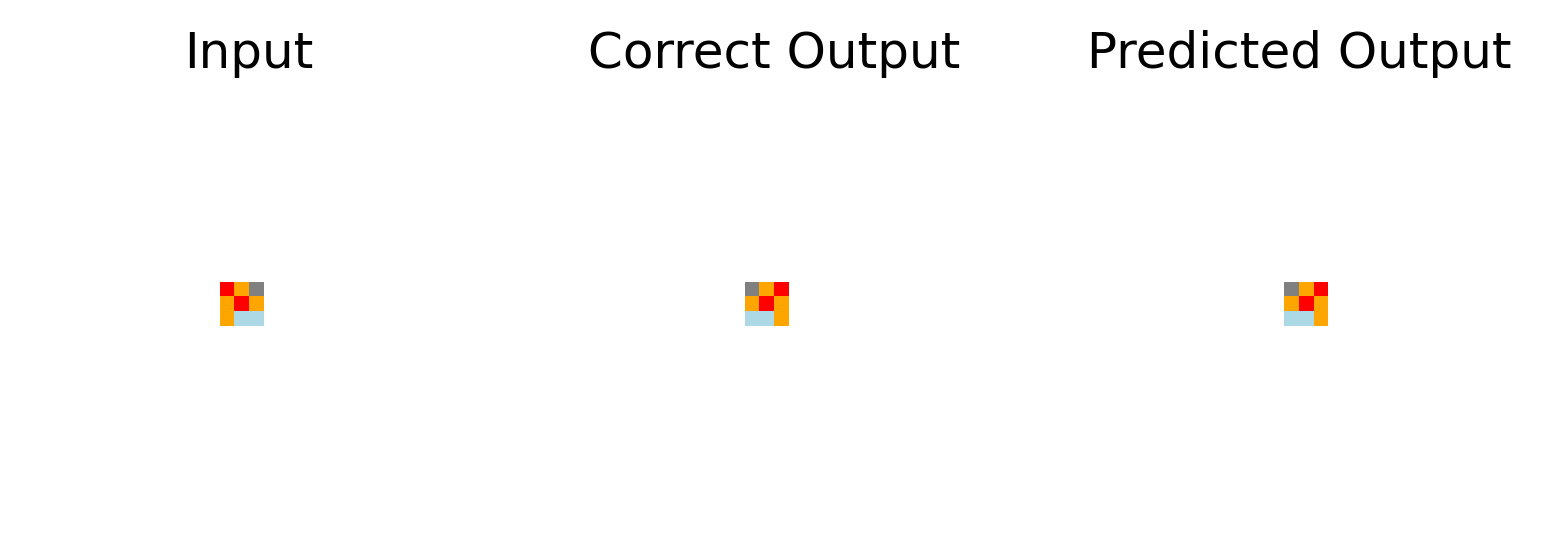

Challenge 68b16354: tensor([0.9988, 0.9991, 0.9984, 1.0000, 0.9984]) => hmirror() after 26.069164276123047ms


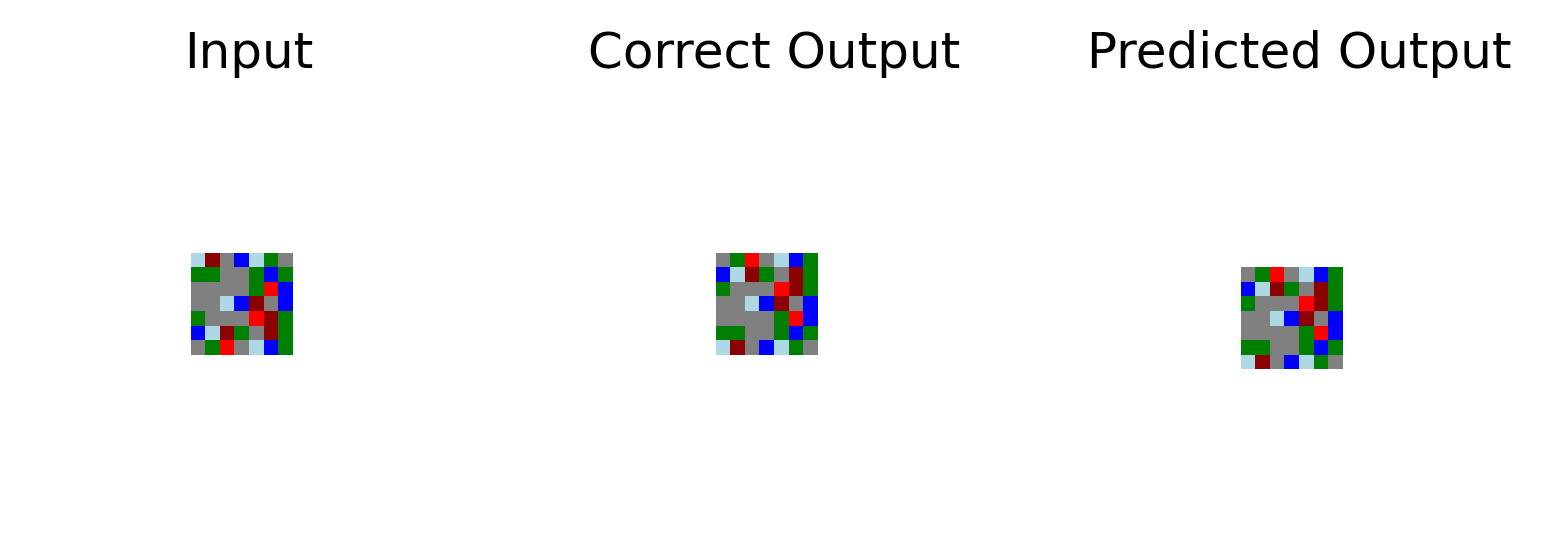

Challenge 74dd1130: tensor([0.9988, 0.9991, 0.9984, 1.0000, 0.9984]) => dmirror() after 42.42658615112305ms


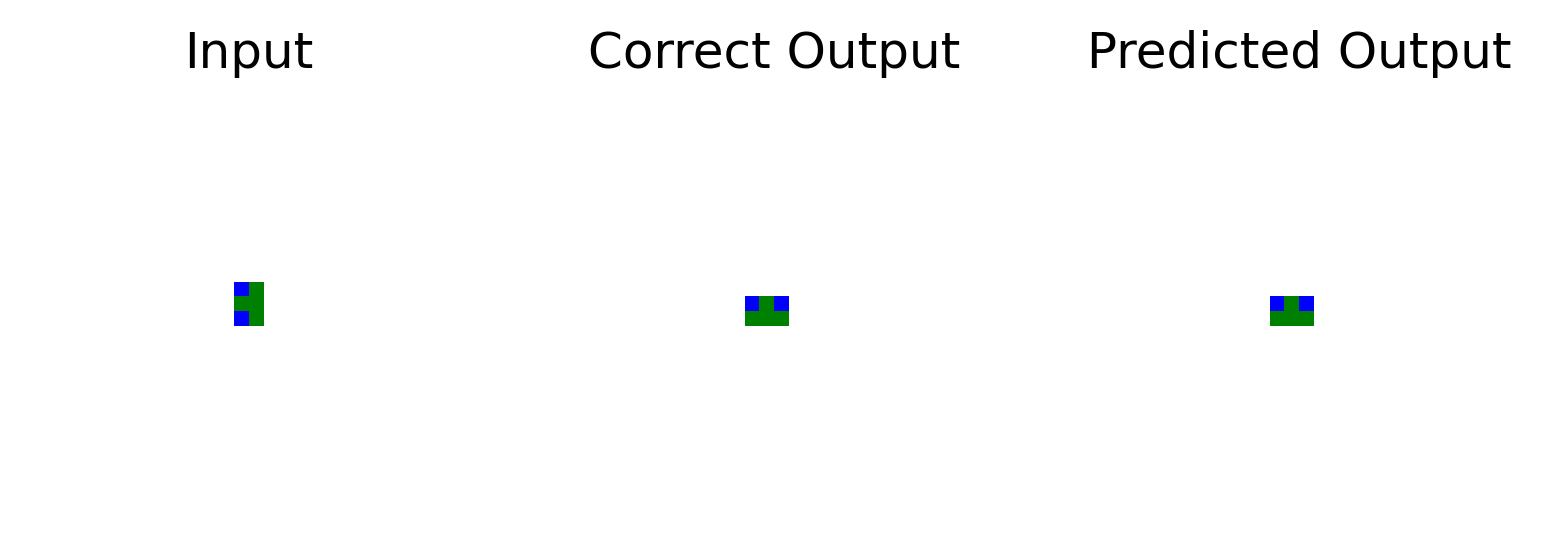

Challenge 3c9b0459: tensor([0.9988, 0.9991, 0.9984, 1.0000, 0.9984]) => rot180() after 38.79046440124512ms


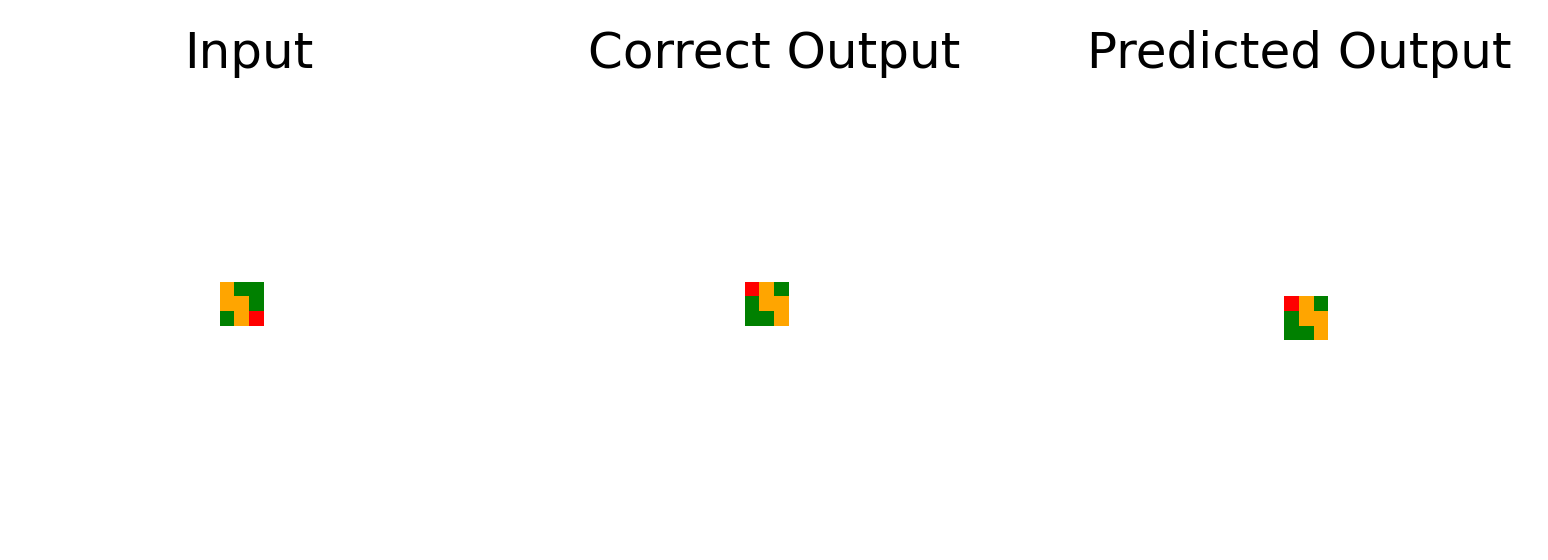

In [15]:
import torch
import time

from torchmetrics.image import StructuralSimilarityIndexMeasure

ssim = StructuralSimilarityIndexMeasure(
    gaussian_kernel=False,
    kernel_size=1,
    data_range=(0, 9),
    reduction=None
)

def dsl_fp(X, y, dsl, p_fn):
    """
    Calculates probability for each function in dsl after it has been applied to X.
    :param X: Input we want to transform into y
    :param y: Target we want to predict based on X
    :param dsl: List of functions to apply to X and calculate the probabilities for
    :param p_fn: Function to calculate function probability for each f in dsl after it has been applied to X. The probability function will receive y as its first and y_pred as its second argument.
    """
    dsl_p = torch.zeros(len(dsl), dtype=torch.float)
    for k, dsl_f in enumerate(dsl):
        y_pred = dsl_apply(dsl_f, X).unsqueeze(0)

        y_pred_unpadded = dataset.blow(dataset.unpad(y_pred.squeeze(0).squeeze(0))).unsqueeze(0).unsqueeze(0)
        y_unpadded = dataset.blow(dataset.unpad(y.squeeze(0).squeeze(0))).unsqueeze(0).unsqueeze(0)
        
        # Calculate similarity between correct solution and after dsl_f has been applied:
        dsl_p[k] += p_fn(y_unpadded, y_pred_unpadded)
    return dsl_p

for challenge_id in ['67a3c6ac', '68b16354', '74dd1130', '3c9b0459']:
    X_samples, y_samples = dataset.get_samples(challenge_id)
    
    start_time = time.time()
    dsl_all_fp = torch.zeros(len(dsl), dtype=torch.float)
    for i, X_sample in enumerate(X_samples):
        dsl_all_fp = dsl_fp(X_sample, y_samples[i], dsl, p_fn=ssim)
    
    # Best match is the dsl_f with the highest ssim score:
    dsl_f_index = dsl_all_fp.argmax()
    end_time = time.time()
    
    challenge_index = dataset.test_challenge_ids.index(challenge_id)
    X, y, _ = dataset.test_challenges[challenge_index]
    y_pred = dsl_apply(dsl[dsl_f_index], X)

    print(f"Challenge {challenge_id}: {dsl_f_ssim} => {dsl_names[dsl_f_index]}() after {(end_time - start_time) * 1000}ms")
    plot.input_and_output(
        X,
        y,
        y_pred=dsl_apply(dsl[dsl_f_index], X)
    )